# Historical Baseball Dashboard

This application is built using Plotly Dash. The app takes historical MLB (Major League Baseball) data and displays team statistics dating from 1903 to 2015. Selecting from a dropdown menu, an era is selected updating the list of available teams and the range set on the years slider. The slider is on a range, allowing the user to adjust the range of years with wich the data shows. This application was intended for me to practice the use of the Python language, basic data analysis, and basic data visualization using Dash.

## The Analysis

The applicaiton breaks down each baseballs teams win/loss performance within a range of the teams history. Additionally, I break down the batting performance with the team batting average, BABIP, and strikeout rate. I also broke down the piching perfomance using the teams ERA and strikeout to walk ratio. Finally the feilding performance of each team is illustrated with total errors and double plays. The graphs are designed with a single CSV file queried with Pandas.

## Dependencies

Dash 1.14
Pandas 1.1
Numpy 1.19.1

## The Data

The data was retrieved from Kaggel and was created by code at https://github.com/benhamner/baseball. It is a processed version of the 2015 data at www.seanlahman.com/baseball-archive/statistics/. The original database was copyright 1996-2015 by Sean Lahman and licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. For details see: http://creativecommons.org/licenses/by-sa/3.0/

### *This notebook was used to flesh out the features and conduct basic analysis*

In [2]:
# Import CSV and Pandas libraries
import csv
import pandas as pd

In [3]:
# Read in the data CSV
teams_df = pd.read_csv('team.csv')

In [4]:
# Look at the colomn layout and data types
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       2390 non-null   int64  
 1   league_id  2390 non-null   object 
 2   team_id    2390 non-null   object 
 3   rank       2390 non-null   int64  
 4   g          2390 non-null   int64  
 5   w          2390 non-null   int64  
 6   l          2390 non-null   int64  
 7   div_win    1260 non-null   object 
 8   wc_win     624 non-null    object 
 9   lg_win     2362 non-null   object 
 10  ws_win     2330 non-null   object 
 11  r          2390 non-null   int64  
 12  ab         2390 non-null   int64  
 13  h          2390 non-null   int64  
 14  double     2390 non-null   int64  
 15  triple     2390 non-null   int64  
 16  hr         2390 non-null   int64  
 17  bb         2390 non-null   int64  
 18  so         2270 non-null   float64
 19  sb         2390 non-null   int64  
 20  cs      

In [5]:
# Look at the dataframe head
teams_df.head()

,year,league_id,team_id,rank,g,w,l,div_win,wc_win,lg_win,...,sv,ha,hra,bba,soa,e,dp,fp,name,park
0,1903,AL,BOS,1,141,91,47,NaN,NaN,Y,...,4,1142,23,269,579,235,86,0.95,Boston Americans,Huntington Avenue Grounds
1,1903,NL,BRO,5,139,70,66,NaN,NaN,N,...,4,1276,18,377,438,284,98,0.95,Brooklyn Superbas,Washington Park III
2,1903,NL,BSN,6,140,58,80,NaN,NaN,N,...,1,1310,30,460,516,351,89,0.93,Boston Beaneaters,South End Grounds III
3,1903,AL,CHA,7,138,60,77,NaN,NaN,N,...,4,1233,23,287,391,297,85,0.94,Chicago White Sox,South Side Park II
4,1903,NL,CHN,3,139,82,56,NaN,NaN,N,...,6,1182,14,354,451,314,78,0.94,Chicago Cubs,West Side Park II


In [8]:
# Create a unique list of names
teams = teams_df['name'].unique()

# Dictionary of for list of key value pairs
team_dict={}
team_dict_list=[]

# Look through the list of team names to create the list of key value pairs
for i in range(len(teams)):
    team_dict['label'] = teams[i]
    team_dict['value'] = teams[i]
    team_dict_list.append(team_dict.copy())

team_dict_list

[{'label': 'Boston Americans', 'value': 'Boston Americans'},
 {'label': 'Brooklyn Superbas', 'value': 'Brooklyn Superbas'},
 {'label': 'Boston Beaneaters', 'value': 'Boston Beaneaters'},
 {'label': 'Chicago White Sox', 'value': 'Chicago White Sox'},
 {'label': 'Chicago Cubs', 'value': 'Chicago Cubs'},
 {'label': 'Cincinnati Reds', 'value': 'Cincinnati Reds'},
 {'label': 'Cleveland Naps', 'value': 'Cleveland Naps'},
 {'label': 'Detroit Tigers', 'value': 'Detroit Tigers'},
 {'label': 'New York Giants', 'value': 'New York Giants'},
 {'label': 'New York Highlanders', 'value': 'New York Highlanders'},
 {'label': 'Philadelphia Athletics', 'value': 'Philadelphia Athletics'},
 {'label': 'Philadelphia Phillies', 'value': 'Philadelphia Phillies'},
 {'label': 'Pittsburgh Pirates', 'value': 'Pittsburgh Pirates'},
 {'label': 'St. Louis Browns', 'value': 'St. Louis Browns'},
 {'label': 'St. Louis Cardinals', 'value': 'St. Louis Cardinals'},
 {'label': 'Washington Senators', 'value': 'Washington Sena

In [10]:
# Create a function that will create a list of teams based on era
def dynamicteams(new,x):
    team_names = teams_df[['year','name']]
    filter_year = team_names[team_names.year <= new[x][1]]
    filter_year = filter_year[filter_year.year >= new[x][0]]
    filter_team = filter_year['name'].unique()
    return filter_team

# list of Era names used here for reference
# era_list = ['Dead Ball','Live Ball','Integration','Expantion','Free Agency','Steroid','Post-Steroid']
# Time list corresponds to the era list
time_list = [(1903,1919),(1920,1941),(1942,1960),(1961,1976),(1977,1993),(1994,2005),(2005,2015)]

# Set list of team names from the 'Integration Era' using the dynamic teams function
teamname = dynamicteams(time_list,2)
teamname

array(['Boston Red Sox', 'Brooklyn Dodgers', 'Boston Braves',
       'Chicago White Sox', 'Chicago Cubs', 'Cincinnati Reds',
       'Cleveland Indians', 'Detroit Tigers', 'New York Giants',
       'New York Yankees', 'Philadelphia Athletics',
       'Philadelphia Phillies', 'Pittsburgh Pirates', 'St. Louis Browns',
       'St. Louis Cardinals', 'Washington Senators',
       'Philadelphia Blue Jays', 'Milwaukee Braves', 'Baltimore Orioles',
       'Cincinnati Redlegs', 'Kansas City Athletics',
       'Los Angeles Dodgers', 'San Francisco Giants'], dtype=object)

In [11]:
# Search find data within a range of years
# set range list
year_range = [1903,1919]
# set range dataframe to teams within given years
range_df= teams_df[(teams_df.year >= year_range[0])&(teams_df.year <= year_range[1])]
range_df

,year,league_id,team_id,rank,g,w,l,div_win,wc_win,lg_win,...,sv,ha,hra,bba,soa,e,dp,fp,name,park
0,1903,AL,BOS,1,141,91,47,NaN,NaN,Y,...,4,1142,23,269,579,235,86,0.95,Boston Americans,Huntington Avenue Grounds
1,1903,NL,BRO,5,139,70,66,NaN,NaN,N,...,4,1276,18,377,438,284,98,0.95,Brooklyn Superbas,Washington Park III
2,1903,NL,BSN,6,140,58,80,NaN,NaN,N,...,1,1310,30,460,516,351,89,0.93,Boston Beaneaters,South End Grounds III
3,1903,AL,CHA,7,138,60,77,NaN,NaN,N,...,4,1233,23,287,391,297,85,0.94,Chicago White Sox,South Side Park II
4,1903,NL,CHN,3,139,82,56,NaN,NaN,N,...,6,1182,14,354,451,314,78,0.94,Chicago Cubs,West Side Park II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,1919,NL,PHI,8,138,47,90,NaN,NaN,N,...,2,1391,40,408,397,219,112,0.96,Philadelphia Phillies,Baker Bowl
284,1919,NL,PIT,4,139,71,68,NaN,NaN,N,...,4,1113,23,263,391,160,89,0.96,Pittsburgh Pirates,Forbes Field
285,1919,AL,SLA,5,140,67,72,NaN,NaN,N,...,4,1255,35,421,415,214,98,0.96,St. Louis Browns,Sportsman's Park IV
286,1919,NL,SLN,7,138,54,83,NaN,NaN,N,...,8,1146,25,415,414,217,112,0.96,St. Louis Cardinals,Robison Field


In [13]:
def listpair(new):
    _dict={}
    _dict_list=[]
    for i in range(len(new)):
        _dict['label'] = new[i]
        _dict['value'] = new[i]
        _dict_list.append(_dict.copy())
    return _dict_list


def dynamicera(new,x):
    team_names = teams_df[['year','name']]
    filter_year = team_names[team_names.year <= new[x][1]]
    filter_year = filter_year[filter_year.year >= new[x][0]]
    filter_team = filter_year['name'].unique()
    return listpair(filter_team)


def dynamicrange(x):
    # Hardcoded list of era time spans
    era_time = [(1903,1919),
                (1920,1941),
                (1942,1960),
                (1961,1976),
                (1977,1993),
                (1994,2005),
                (2006,2015)]
    filter_range = [era_time[x][0],era_time[x][1]]
    return filter_range


era_list = [{'label': 'Dead Ball','value': 'Dead Ball'},{'label': 'Live Ball','value': 'Live Ball'},{'label': 'Integration','value': 'Integration'},{'label': 'Expantion','value': 'Expantion'},{'label': 'Free Agency','value': 'Free Agency'},{'label': 'Steroid','value': 'Steroid'},{'label': 'Post-Steroid','value': 'Post-Steroid'}]
time_list = [(1903,1919),(1920,1941),(1942,1960),(1961,1976),(1977,1993),(1994,2005),(2005,2015)]
era_teams = dynamicera(time_list,1)
year_range = dynamicrange(1)
print(era_list[1]['value'])
print(year_range)
print(era_teams)

Live Ball
[1920, 1941]
[{'label': 'Boston Red Sox', 'value': 'Boston Red Sox'}, {'label': 'Brooklyn Robins', 'value': 'Brooklyn Robins'}, {'label': 'Boston Braves', 'value': 'Boston Braves'}, {'label': 'Chicago White Sox', 'value': 'Chicago White Sox'}, {'label': 'Chicago Cubs', 'value': 'Chicago Cubs'}, {'label': 'Cincinnati Reds', 'value': 'Cincinnati Reds'}, {'label': 'Cleveland Indians', 'value': 'Cleveland Indians'}, {'label': 'Detroit Tigers', 'value': 'Detroit Tigers'}, {'label': 'New York Giants', 'value': 'New York Giants'}, {'label': 'New York Yankees', 'value': 'New York Yankees'}, {'label': 'Philadelphia Athletics', 'value': 'Philadelphia Athletics'}, {'label': 'Philadelphia Phillies', 'value': 'Philadelphia Phillies'}, {'label': 'Pittsburgh Pirates', 'value': 'Pittsburgh Pirates'}, {'label': 'St. Louis Browns', 'value': 'St. Louis Browns'}, {'label': 'St. Louis Cardinals', 'value': 'St. Louis Cardinals'}, {'label': 'Washington Senators', 'value': 'Washington Senators'}, {'

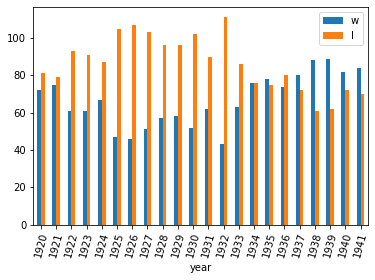

In [80]:
# After selecting Era, Team list is updated along with range
# This filter dataframe represents the range being applied
filter_df = teams_df[(teams_df.year >= 1920)&(teams_df.year <= 1941)]
# This is the plot of the filtered data
filter_df[filter_df.name == 'Boston Red Sox'].plot.bar(x='year',y=['w','l'],rot=75)
# If the above example of features are applied the graph should look similar
# WIN LOSE BAR GRAPH OF THE BOSTON RED SOX DURING THE LIVE BALL ERA

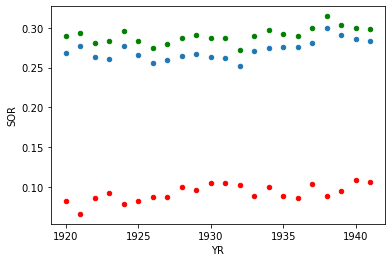

In [98]:
import matplotlib.pyplot as plt

ax = plt.gca()

# BABIP, Batting Avg, Strike Out Rate
# Continuing using the filterd data from above
YR = filter_df[filter_df.name == 'Boston Red Sox'].year
AB = filter_df[filter_df.name == 'Boston Red Sox'].ab
Ht = filter_df[filter_df.name == 'Boston Red Sox'].h
SO = filter_df[filter_df.name == 'Boston Red Sox'].so
BB = filter_df[filter_df.name == 'Boston Red Sox'].bb
HR = filter_df[filter_df.name == 'Boston Red Sox'].hr
SOR = SO / AB
# Calculate BABIP
BABIP = (Ht - HR) / (AB - SO - HR)
# Calculete Batting Average
BAVG = Ht / AB

Data = {'YR': YR,
        'BABIP': BABIP,
        'BAVG': BAVG,
        'SOR': SOR,
       }

df = pd.DataFrame(Data,columns=['YR','BABIP','BAVG','SOR'])
df.plot.scatter(x='YR', y='BABIP',ax=ax,color='green')
df.plot.scatter(x='YR', y='BAVG',ax=ax)
df.plot.scatter(x='YR', y='SOR',ax=ax,color='red')
plt.show()

KeyError: 'SBR'

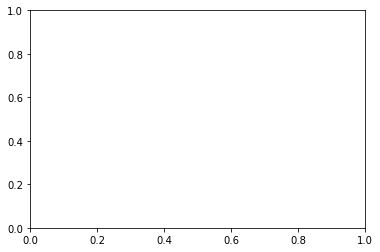

In [103]:
# ERA SOA BBA
ax = plt.gca()

YR = filter_df[filter_df.name == 'Boston Red Sox'].year
ERA = filter_df[filter_df.name == 'Boston Red Sox'].era
SOA = filter_df[filter_df.name == 'Boston Red Sox'].soa
BBA = filter_df[filter_df.name == 'Boston Red Sox'].bba

SBR = SOA / BBA

Data = {'YR': YR,
        'ERA': ERA,
        'SBR': SBR
       }

df = pd.DataFrame(Data,columns=['YR','ERA','SBR'])
# df.plot.scatter(x='YR', y='ERA')
df.plot.scatter(x='YR', y='SBR',ax=ax,color='red')
df.plot.scatter(x='YR', y='ERA',ax=ax,color='green')
plt.show()